In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.linalg import expm

In [2]:
Z = np.array([[1, 0], 
              [0, -1]])

Y = np.array([[0, -1j],
              [1j, 0]])

X = np.array([[0, 1],
              [1, 0]])

I = np.array([[1, 0],
              [0 ,1]])

Hadamard = (1/np.sqrt(2))*np.array([[1, 1],
                                    [1, -1]])

zero_state = np.array([1, 0])
plus_state = Hadamard @ zero_state

In [3]:
def apply_hadamard(num_qubits, state):
    Hadamard = (1/np.sqrt(2))*np.array([[1, 1],
                                    [1, -1]])
    operator = [Hadamard]*num_qubits
    return reduce(np.kron, operator) @ state

## Single qubit

In [4]:
np.random.seed(20)

In [5]:
hamiltonian = Z

w, v = np.linalg.eigh(hamiltonian)
ground_state = v[:, 0]
gs_energy = w[0]

print("Ground state energy:", gs_energy)
print("Ground state:", ground_state)

Ground state energy: -1.0
Ground state: [0. 1.]


In [6]:
def weak_measurement(state, H, eps=0.01):
    new_state = np.kron(plus_state, state)
    new_state = expm(-1j * eps * np.kron(Y, H)) @ new_state
    probs = np.abs(new_state)**2
    prob = np.sum(probs[:len(probs)//2])
    if np.random.rand() < prob:
        return new_state[:len(probs)//2] / np.sqrt(prob), 0
    return new_state[len(probs)//2:] / np.sqrt(1 - prob), 1

In [7]:
def random_state(n):
    vector_size = 2 ** n
    real_part = np.random.randn(vector_size)
    imag_part = np.random.randn(vector_size)
    complex_vector = real_part + 1j * imag_part
    return complex_vector / np.linalg.norm(complex_vector)

In [8]:
class GaussianFeedback:
    def __init__(self, eps, Eth):
        self.k0 = 0
        self.k1 = 0
        self.eps = eps
        self.Eth = Eth

    def _x_max(self):
        if self.k0 == 0 and self.k1 == 0:
            return 1
        return np.arcsin((self.k1 - self.k0)/(self.k1 + self.k0)) / 2

    def cond(self):
        val = self._x_max()
        if val > self.eps * self.Eth:
            self.k0 = 0
            self.k1 = 0
            return val, True
        return val, False        

    def update(self, m):
        self.k0 += (1 - m)
        self.k1 += m

In [9]:
def fidelity(s1, s2):
    return np.abs(s1.conj() @ s2)**2

In [10]:
def plot(x_maxes, fidelities, Eth):
    x_max_mean = np.mean(x_maxes, axis=0)
    x_max_std = np.std(x_maxes, axis=0)

    x_max_upper = x_max_mean + x_max_std
    x_max_lower = x_max_mean - x_max_std

    fid_mean = np.mean(fidelities, axis=0)
    fid_std = np.std(fidelities, axis=0)

    fid_upper = fid_mean + fid_std
    fid_lower = fid_mean - fid_std

    x = range(len(x_max_mean))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    ax1.plot(fid_mean, label='Fidelity')
    ax1.plot(fid_upper, color='tab:blue', alpha=0.1)
    ax1.plot(fid_lower, color='tab:blue', alpha=0.1)
    ax1.axhline(y=1.0, color="purple", ls="--", lw=2, label="Target: 1.0")
    ax1.fill_between(x, fid_lower, fid_upper, alpha=0.2)
    ax1.legend()

    # Add labels and title
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Fidelity")
    ax1.set_title("Fidelity vs iterations")

    ax2.plot(x_max_mean, label='x_max')
    ax2.plot(x_max_upper, color='tab:blue', alpha=0.1)
    ax2.plot(x_max_lower, color='tab:blue', alpha=0.1)
    ax2.axhline(y=Eth, color="purple", ls="--", lw=2, label=f"Eth: {Eth}")
    ax2.fill_between(x, x_max_lower, x_max_upper, alpha=0.2)
    ax2.legend()

    # Add labels and title
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("x_max")
    ax2.set_title("x_max vs iterations")

    # Show the plot
    plt.show()

In [11]:
state = plus_state # as mentioned in the paper
eps = 0.2
Eth = 0.0
feedback = GaussianFeedback(eps, Eth)

fidelities = []
x_maxes = []

for _ in range(1000):
    temp_fidelities = []
    temp_x_maxes = []
    for i in range(40):
        state, m = weak_measurement(state, hamiltonian, eps)
        feedback.update(m)
        x_max, cond = feedback.cond()
        temp_x_maxes.append(x_max)
        if cond:
            state = X @ state
        temp_fidelities.append(fidelity(state, ground_state))
    x_maxes.append(temp_x_maxes.copy())
    fidelities.append(temp_fidelities.copy())

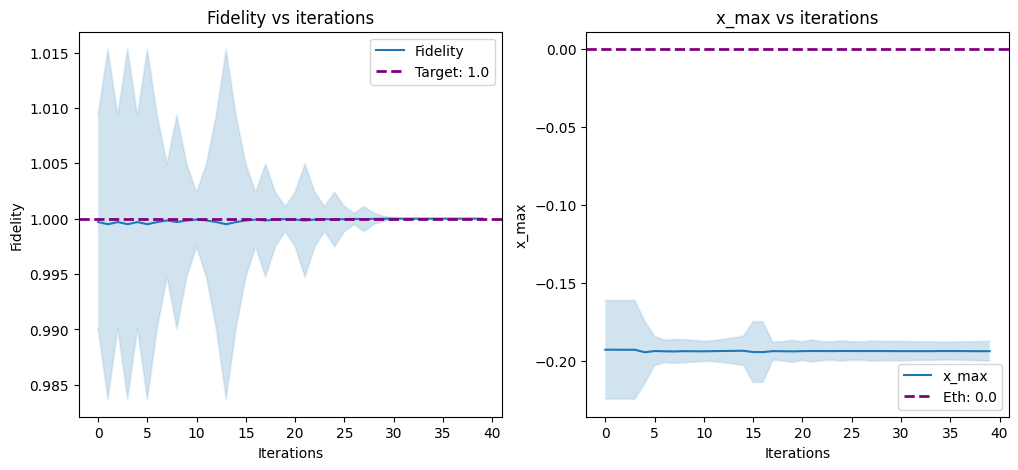

In [12]:
plot(x_maxes, fidelities, Eth)

In [13]:
def get_hamiltonian(hamiltonian_terms, coefficients):
    n = 2 ** len(hamiltonian_terms[0])
    hamiltonian = np.zeros((n, n), dtype=np.complex128)
    for i in range(len(hamiltonian_terms)):
        term = hamiltonian_terms[i]
        coeff = coefficients[i]
        operator = 1
        for j in range(len(term)):
            if term[j] == 'X':
                operator = np.kron(operator, np.array([[0, 1], [1, 0]]))
            elif term[j] == 'Y':
                operator = np.kron(operator, np.array([[0, -1j], [1j, 0]]))
            elif term[j] == 'Z':
                operator = np.kron(operator, np.array([[1, 0], [0, -1]]))
            elif term[j] == 'I':
                operator = np.kron(operator, np.array([[1, 0], [0, 1]]))
        hamiltonian += coeff * operator
    return hamiltonian

In [14]:
def random_param_circuit(num_qubits):
    """
    Returns the matrix of a randomly parameterized quantum circuit with Rx, Ry, Rz gates applied
    on every qubit with random parameters.

    Args:
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        ndarray: The matrix of the quantum circuit.
    """
    
    # Generate random parameters for Rx, Ry, Rz gates
    thetas = np.random.uniform(0, 2 * np.pi, size=(num_qubits, 3))
    
    # Generate matrix for each X, Y, Z gate
    Z = np.array([[1, 0], 
                  [0, -1]])

    Y = np.array([[0, -1j],
                  [1j, 0]])

    X = np.array([[0, 1],
                  [1, 0]])

    # Compute matrix for the quantum circuit
    operators = []
    for i in range(num_qubits):
        Rx = expm(-1j * thetas[i,0] * X / 2)
        Ry = expm(-1j * thetas[i,1] * Y / 2)
        Rz = expm(-1j * thetas[i,2] * Z / 2)
        operators.append(Rz @ Ry @ Rx)
    
    circuit_matrix = reduce(np.kron, operators)
    return circuit_matrix

## Heisenberg model

In [15]:
np.random.seed(20)

In [16]:
L = 3

ops = []
coeffs = []
id_op = ['I']*L

for op in ['X','Y','Z']:
    for i in range(L-1):
        temp_op = id_op.copy()
        temp_op[i] = op
        temp_op[i+1] = op
        ops.append(''.join(temp_op))
        coeffs.append(1.0)

hamiltonian = get_hamiltonian(ops, coeffs)
w, v = np.linalg.eigh(hamiltonian)
ground_state = v[:, 0]
gs_energy = w[0]

print("Ground state energy:", gs_energy)
print("Ground state:", ground_state)

Ground state energy: -4.0
Ground state: [-0.        +0.j  0.40824829+0.j -0.81649658+0.j  0.        +0.j
  0.40824829+0.j -0.        +0.j -0.        +0.j -0.        +0.j]


In [17]:
ops

['XXI', 'IXX', 'YYI', 'IYY', 'ZZI', 'IZZ']

In [18]:
random_circuit = random_param_circuit(L)

In [19]:
state = random_state(L)
eps = 0.12
Eth = -0.4
feedback = GaussianFeedback(eps, Eth)

fidelities = []
x_maxes = []

for _ in range(50):
    temp_fidelities = []
    temp_x_maxes = []
    for i in range(100):
        state, m = weak_measurement(state, hamiltonian, eps)
        feedback.update(m)
        x_max, cond = feedback.cond()
        temp_x_maxes.append(x_max)
        if cond:
            state = random_circuit @ state
        temp_fidelities.append(fidelity(state, ground_state))
    x_maxes.append(temp_x_maxes.copy())
    fidelities.append(temp_fidelities.copy())

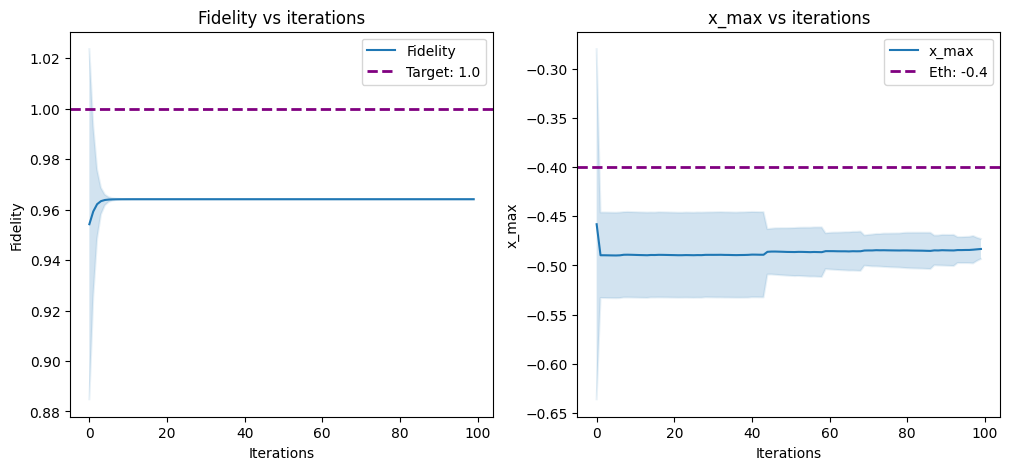

In [20]:
plot(x_maxes, fidelities, Eth) 

## TFIM

In [21]:
np.random.seed(20)

In [22]:
L = 5
lmbd = -1.0

ops = []
coeffs = []
id_op = ['I']*L

for i in range(L):
    temp_op = id_op.copy()
    temp_op[i] = 'X'
    ops.append(''.join(temp_op))
    coeffs.append(lmbd)

for i in range(L-1):
    temp_op = id_op.copy()
    temp_op[i] = 'Z'
    temp_op[i+1] = 'Z'
    ops.append(''.join(temp_op))
    coeffs.append(-1.0)

hamiltonian = get_hamiltonian(ops, coeffs)
w, v = np.linalg.eigh(hamiltonian)
ground_state = v[:, 0]
gs_energy = w[0]

print("Ground state energy:", gs_energy)
print("Ground state:", ground_state)

Ground state energy: -6.026674183332274
Ground state: [-0.43696962+0.j -0.22770861+0.j -0.14579953+0.j -0.18918715+0.j
 -0.13857876+0.j -0.08665612+0.j -0.1124436 +0.j -0.18918715+0.j
 -0.14579953+0.j -0.08149059+0.j -0.05859532+0.j -0.08665612+0.j
 -0.1124436 +0.j -0.08149059+0.j -0.12260489+0.j -0.22770861+0.j
 -0.22770861+0.j -0.12260489+0.j -0.08149059+0.j -0.1124436 +0.j
 -0.08665612+0.j -0.05859532+0.j -0.08149059+0.j -0.14579953+0.j
 -0.18918715+0.j -0.1124436 +0.j -0.08665612+0.j -0.13857876+0.j
 -0.18918715+0.j -0.14579953+0.j -0.22770861+0.j -0.43696962+0.j]


In [23]:
ops

['XIIII',
 'IXIII',
 'IIXII',
 'IIIXI',
 'IIIIX',
 'ZZIII',
 'IZZII',
 'IIZZI',
 'IIIZZ']

In [24]:
random_circuit = random_param_circuit(L)

In [25]:
state = np.array([1] + [0]*(2**L - 1), dtype=np.complex128)
state = apply_hadamard(L, state)
eps = 0.12
Eth = 0.0
feedback = GaussianFeedback(eps, Eth)

fidelities = []
x_maxes = []

for _ in range(20):
    temp_fidelities = []
    temp_x_maxes = []
    for i in range(100):
        state, m = weak_measurement(state, hamiltonian, eps)
        feedback.update(m)
        x_max, cond = feedback.cond()
        temp_x_maxes.append(x_max)
        if cond:
            state = random_circuit @ state
        temp_fidelities.append(fidelity(state, ground_state))
    x_maxes.append(temp_x_maxes.copy())
    fidelities.append(temp_fidelities.copy())

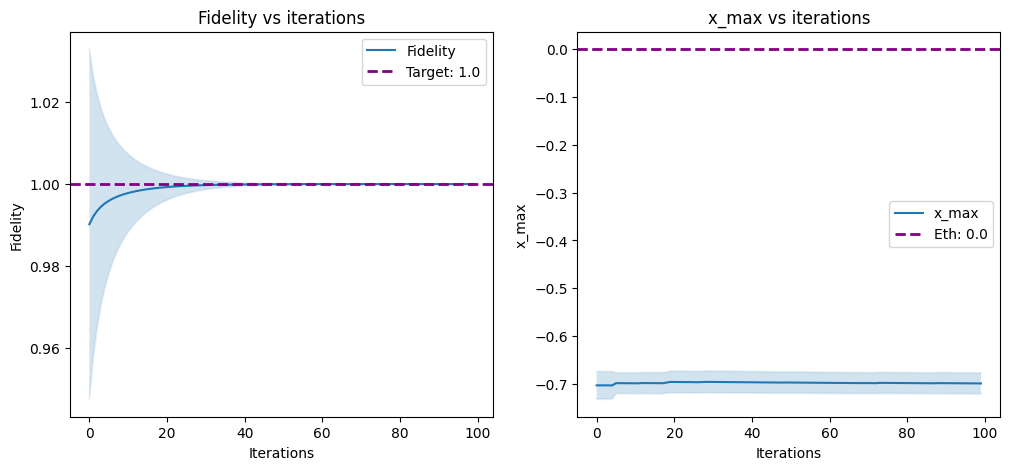

In [26]:
plot(x_maxes, fidelities, Eth)